# Resample a DES cluster lensing chain with two parameters

In this example, we will read in a DES Year 1 cluster weak lensing chain with two parameters ($\log_{10}M$,$c$) and build an importance sampler for it. We will then resample it and try to recover (essentially) the exact same chain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.optimize as op
import corner #for making corner plots
import emcee #for doing MCMC
%matplotlib inline

In [2]:
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Read in the chain and remove burn-in (which I only know is there for this example)
input_chain = np.loadtxt("DES_RMWL_Mc_chainz0l3.txt")[32*1000:]
lnpost = np.loadtxt("DES_RMWL_Mc_likesz0l3.txt")[32*1000:]
print("chain shape is  ", input_chain.shape)
print("lnpost shape is ", lnpost.shape)
print np.min(lnpost), np.max(lnpost)

('chain shape is  ', (64000, 2))
('lnpost shape is ', (64000,))
-115.54427891774128 -105.32040903997436


In [4]:
#Pick out only 100 training points
N_training = 100
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 8)
IS.select_training_points(N_training, method="LH")

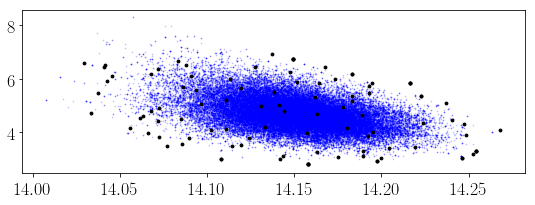

In [6]:
#Visualize the training points selected against the chain
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,3))
plt.subplots_adjust(wspace=0.6)
ax.scatter(input_chain[:,0], input_chain[:,1], c='b', s=0.5, alpha=0.2)

points,_ = IS.get_training_data()
ax.scatter(points[:,0], points[:,1], c='k', s=8)

In [7]:
#Train the GP inside of the sampler
IS.train()

In [9]:
#Run an optimizer to see if we can recover the MLE
def neg_lnpost_predicted(p):
    return -IS.predict(p)
guess = input_chain[np.argmax(lnpost)]
result = op.minimize(neg_lnpost_predicted, guess, method="Nelder-Mead")
print(result)

 final_simplex: (array([[14.15558351,  4.57302597],
       [14.15558535,  4.57296759],
       [14.15558303,  4.57295906]]), array([105.32053879, 105.32053879, 105.32053879]))
           fun: 105.32053878842878
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 33
        status: 0
       success: True
             x: array([14.15558351,  4.57302597])


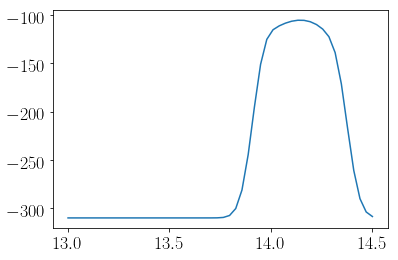

In [10]:
#Make slice plots to see if things are working
lMs = np.linspace(13., 14.5)
cs = 5*np.ones_like(lMs)
ps = np.array([lMs,cs]).T
plt.plot(lMs, IS.predict(ps))

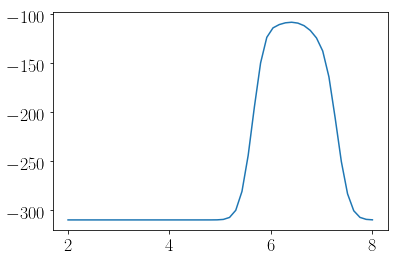

In [11]:
cs = np.linspace(2, 8)
lMss = 14.5*np.ones_like(lMs)
ps = np.array([lMs,cs]).T
plt.plot(cs, IS.predict(ps))

In [12]:
nwalkers = 32
ndim = len(input_chain[0])
pos = np.array([result.x + result.x*1e-3*np.random.randn(ndim) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, ndim, IS.predict)
_ = sampler.run_mcmc(pos, 3000)
test_chain = sampler.flatchain[nwalkers*1000:]

In [13]:
print np.mean(input_chain, 0), np.std(input_chain, 0)
print np.mean(test_chain, 0), np.std(test_chain, 0)

[14.14967048  4.69976706] [0.03211171 0.60469267]
[14.15032669  4.69191928] [0.03205429 0.59529463]


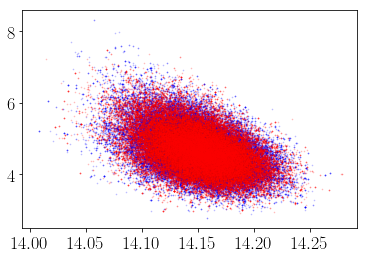

In [14]:
fig, ax = plt.subplots()
ax.scatter(input_chain[:,0], input_chain[:,1], c='b', s=0.5, alpha=0.2)
ax.scatter(test_chain[:,0], test_chain[:,1], c='r', s=0.5, alpha=0.2)

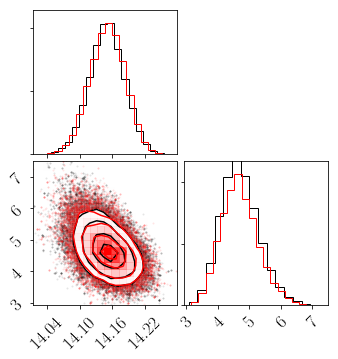

In [15]:
fig = corner.corner(input_chain)
fig = corner.corner(test_chain, fig=fig, color='r')